# Dataset and Dataloader creation

In [17]:
import os
import mne
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from mne_bids import read_raw_bids, BIDSPath
import numpy as np

class BIDSEEGDataset(Dataset):
    def __init__(self, bids_root, patients_tsv, binary=False):
        self.bids_root = bids_root
        self.binary = binary

        # use only these channels for classification
        self.selected_channels = ['F3','F4','C3','C4','O1','O2','A1','A2']

        # read the patients.tsv file
        self.patients_df = pd.read_csv(patients_tsv, delimiter='\t')

        # create a dictionary with patient_id as key and pathology as value
        self.pathology_dict = dict(zip(self.patients_df['participant_id'], self.patients_df['pathology']))

        # get all the subjects in the bids_root
        self.subjects = [d for d in os.listdir(bids_root) if d.startswith('sub-')] # ['sub-03'] #
        self.all_epochs = []
        self.all_labels = []

        for subject in self.subjects:
            subject_id = subject.replace('sub-', '')
            subject_folder = os.path.join(self.bids_root, subject)
            sessions = [d for d in os.listdir(subject_folder) if d.startswith('ses-')]

            for session in sessions:
                session_id = session.replace('ses-', '')
                bids_path = BIDSPath(subject=subject_id, session=session_id, task='verbalWM',
                                              run='01', datatype='eeg', root=self.bids_root)
                try:
                    raw = read_raw_bids(bids_path, verbose=False)
                except:
                    continue

                raw.load_data(verbose=False)
                
                raw.filter(l_freq=1, h_freq=None, verbose=False, fir_design='firwin', skip_by_annotation='edge')
                raw.pick(picks=self.selected_channels, verbose=False)
                raw.resample(sfreq=250)  # Resample to 250 Hz


                events, _ = mne.events_from_annotations(raw, verbose=False)
                epochs = mne.Epochs(raw, events, verbose=False, tmax=8)
                pathology_label = self.pathology_dict.get(f'sub-{subject_id}', 'Unknown')
                for epoch_data in epochs.get_data():
                    self.all_epochs.append(epoch_data)
                    if binary:
                        if pathology_label == 'hippocampal sclerosis':
                            self.all_labels.append('hippocampal sclerosis')
                        else:
                            self.all_labels.append('other')
                    else:
                        self.all_labels.append(pathology_label)

        # save the labels in a dictionary to convert them to numbers
        # and to easily use them in the dataloader
        if not binary:
            self.labels = {}
            for i, pathology in enumerate(set(self.all_labels)):
                self.labels[pathology] = i
        else:
            self.labels = {
                'hippocampal sclerosis': 0,
                'other': 1
            }


    def __len__(self):
        return len(self.all_epochs)

    def __getitem__(self, idx):
        epoch_data = self.all_epochs[idx]
        pathology_label = self.all_labels[idx]
        # create one hot encoding for the pathology
        if self.binary:
            if pathology_label == 'hippocampal sclerosis':
                label = torch.tensor(0)
            else:
                label = torch.tensor(1)
        else: 
            label = torch.tensor(self.labels[pathology_label])

        return torch.tensor(epoch_data, dtype=torch.float32), label
    
    @property
    def class_weights(self):
        # Count the number of samples for each class
        class_counts = {}
        for label in self.all_labels:
            class_counts[label] = class_counts.get(label, 0) + 1

        # Compute the inverse of class counts
        # and normalize so that the weights sum to 1
        total_samples = len(self.all_labels)
        weights = [total_samples/class_counts[label] for label in self.labels.keys()]
        norm_weights = np.array(weights) / sum(weights)

        return torch.tensor(norm_weights, dtype=torch.float32)

In [18]:
from torch.nn.utils.rnn import pad_sequence

# Initialize the custom dataset
bids_root = 'data'
patients_tsv = 'data/participants.tsv'
dataset = BIDSEEGDataset(bids_root, patients_tsv, binary=False)
dataset_binary = BIDSEEGDataset(bids_root, patients_tsv, binary=True)

# dataset stats
print(f'Total number of samples: {len(dataset)}')

/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Invalid date encountered (2023-09-13 14:23:60).
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 43 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 34 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 47 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 46 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 47 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Invalid date encountered (2023-09-13 14:23:60).
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 43 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 34 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


Using data from preloaded Raw for 47 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 46 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 48 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 47 events and 2051 original time points ...
2 bad epochs dropped


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)
/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding ou

Using data from preloaded Raw for 50 events and 2051 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 49 events and 2051 original time points ...
2 bad epochs dropped
Total number of samples: 3217


/var/folders/zb/vnlk96b52x18jnx35vjsd4f40000gp/T/ipykernel_8656/3712927718.py:38: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_bids(bids_path, verbose=False)


In [19]:
# Create test, validation and train splits
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Split the dataset into training and a temporary set (70% train, 30% temp)
# we need this to not loose the `all_labels` list
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,
    random_state=42,
    stratify=dataset.all_labels,
    shuffle=True
)

train_indices_binary, temp_indices_binary = train_test_split(
    list(range(len(dataset_binary))),
    test_size=0.3,
    random_state=42,
    stratify=dataset_binary.all_labels,
    shuffle=True
)

# Split the temporary set into validation and test sets (50% validation, 50% test of the temp set)
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,
    random_state=42,
    stratify=[dataset.all_labels[i] for i in temp_indices],
    shuffle=True
)

val_indices_binary, test_indices_binary = train_test_split(
    temp_indices_binary,
    test_size=0.5,
    random_state=42,
    stratify=[dataset_binary.all_labels[i] for i in temp_indices_binary],
    shuffle=True
)

# Create Subset instances using the split indices
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_dataset_binary = Subset(dataset_binary, train_indices_binary)
val_dataset_binary = Subset(dataset_binary, val_indices_binary)
test_dataset_binary = Subset(dataset_binary, test_indices_binary)


In [20]:
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create a data loader for the binary dataset
train_loader_binary = DataLoader(train_dataset_binary, batch_size=batch_size, shuffle=True)
val_loader_binary = DataLoader(val_dataset_binary, batch_size=batch_size, shuffle=False)
test_loader_binary = DataLoader(test_dataset_binary, batch_size=batch_size, shuffle=False)

# EEGNet

In [43]:
from torch import nn
import torch.nn.functional as F
from torch import optim

class EEGNet(nn.Module):
    def __init__(self, Chans=8, Samples=2051, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout', outputs=2, activation='ReLU'):
        super(EEGNet, self).__init__()
        
        self.activation = activation
        # First Convolutional Block
        self.block1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding=(0, kernLength // 2), bias=False),
            nn.BatchNorm2d(F1),
            self.get_activation_function(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )
        
        # Depthwise Convolution
        self.depthwise = nn.Conv2d(F1, F1*D, (Chans, 1), groups=F1, bias=False)
        self.depthwise_bn = nn.BatchNorm2d(F1*D)
        self.depthwise_activation = self.get_activation_function()
        
        # Separable Convolution
        self.pointwise = nn.Conv2d(F1*D, F2, (1, 1), bias=False)
        self.pointwise_bn = nn.BatchNorm2d(F2)
        self.pointwise_activation = self.get_activation_function()
        self.pointwise_pooling = nn.AvgPool2d((1, 8))
        self.pointwise_dropout = nn.Dropout(dropoutRate)
        
        # Classification Layer
        self.classify = nn.Linear(F2, outputs)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.block1(x)
        
        # Depthwise Convolution
        x = self.depthwise(x)
        x = self.depthwise_bn(x)
        x = self.depthwise_activation(x)
        
        # Separable Convolution
        x = self.pointwise(x)
        x = self.pointwise_bn(x)
        x = self.pointwise_activation(x)
        x = self.pointwise_pooling(x)
        x = self.pointwise_dropout(x)
        
        x = F.adaptive_avg_pool2d(x, (1, 1)).squeeze()
        x = self.classify(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def get_activation_function(self):
        # return the activation function with switch
        if self.activation == 'ReLU':
            return nn.ReLU()
        elif self.activation == 'LeakyReLU':
            return nn.LeakyReLU()
        elif self.activation == 'ELU':
            return nn.ELU()
        elif self.activation == 'SELU':
            return nn.SELU()
        else:
            return nn.ReLU()
            


# Training

In [57]:
import torch
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score

def train_model(model, train_loader, val_loader, test_loader, epochs=100, device = 'cpu', learning_rate=1e-3, weights=None):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(weight=weights)

    best_val_accuracy = 0.0  # To keep track of the best validation accuracy

    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []

    best_model = None

    # Training loop
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()  # Set the model to training mode
        total_loss = 0.0
        correct = 0
        total = 0
        total_f1_score = 0.0
        # Training Phase
        for _, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)

            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            total_f1_score += f1_score(labels.cpu(), predicted.cpu(), average='macro')

        train_accuracy = 100.*correct/total
        train_losses.append(total_loss/len(train_loader))
        train_accuracies.append(train_accuracy)
        t_f1 = total_f1_score/len(train_loader)
        train_f1_scores.append(t_f1)
        
        # Validation Phase
        model.eval()  # Set the model to evaluation mode
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        val_f1_score = 0.0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                val_loss += loss.item()
                val_f1_score += f1_score(labels.cpu(), predicted.cpu(), average='macro')
        
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(val_accuracy)
        v_f1 = val_f1_score/len(val_loader)
        val_f1_scores.append(v_f1)
        
        pbar.set_description(f"Epoch [{epoch+1}/{epochs}], Training Loss: {total_loss/len(train_loader):.4f}, Training F1: {t_f1:.2f}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation F1: {v_f1:.2f}")
        
        # Save the model if it has the best validation accuracy so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # deep copy model
            best_model = model.state_dict().copy()

    # Final test on the test dataset
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0
    test_f1_score = 0.0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            test_f1_score += f1_score(labels.cpu(), predicted.cpu(), average='macro')

    test_f1_score = test_f1_score/len(test_loader)
    test_accuracy = 100. * test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test F1 Score: {test_f1_score:.4f}")
    return best_model, train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores


In [58]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")

# Initialize the model, criterion, and optimizer
model = EEGNet(outputs=len(dataset.labels), activation='ReLU').to(device)
model, train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores = train_model(
    model, train_loader, val_loader, test_loader, epochs=num_epochs, device=device, learning_rate=learning_rate, weights=dataset.class_weights.to(device)
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [100/100], Training Loss: 0.2266, Training F1: 0.83, Validation Loss: 0.5054, Validation F1: 0.66: 100%|██████████| 100/100 [02:06<00:00,  1.26s/it]

Test Accuracy: 63.66%
Test F1 Score: 0.6525


In [34]:
learning_rate = 0.0001
num_epochs = 200

model_binary = EEGNet(outputs=len(dataset_binary.labels)).to(device)
model_binary, train_losses_binary, val_losses_binary, train_accuracies_binary, val_accuracies_binary, train_f1_scores_binary, val_f1_scores_binary = train_model(
    model_binary, train_loader_binary, val_loader_binary, test_loader_binary, epochs=num_epochs, device=device, learning_rate=learning_rate, weights=dataset_binary.class_weights.to(device)
)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [200/200], Training Loss: 0.1423, Training Accuracy: 94.62%, Validation Loss: 0.1494, Validation Accuracy: 93.37%: 100%|██████████| 200/200 [03:47<00:00,  1.14s/it]

Test Accuracy: 93.79%


# Plot results

In [52]:
from matplotlib import pyplot as plt

def plot_training(train_accuracies, val_accuracies, train_losses, val_losses, train_f1_scores, val_f1_scores, title):
    # Create a figure with 1 row and 3 columns
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # Plot training and validation accuracy on the first axis
    ax1.plot(train_accuracies, label='Training Accuracy')
    ax1.plot(val_accuracies, label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()

    # Plot training and validation loss on the second axis
    ax2.plot(train_losses, label='Training Loss')
    ax2.plot(val_losses, label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Plot training and validation F1 score on the third axis
    ax3.plot(train_f1_scores, label='Training F1 Score')
    ax3.plot(val_f1_scores, label='Validation F1 Score')
    ax3.set_title('Training and Validation F1 Score')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('F1 Score')
    ax3.legend()

    # Display the plots
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


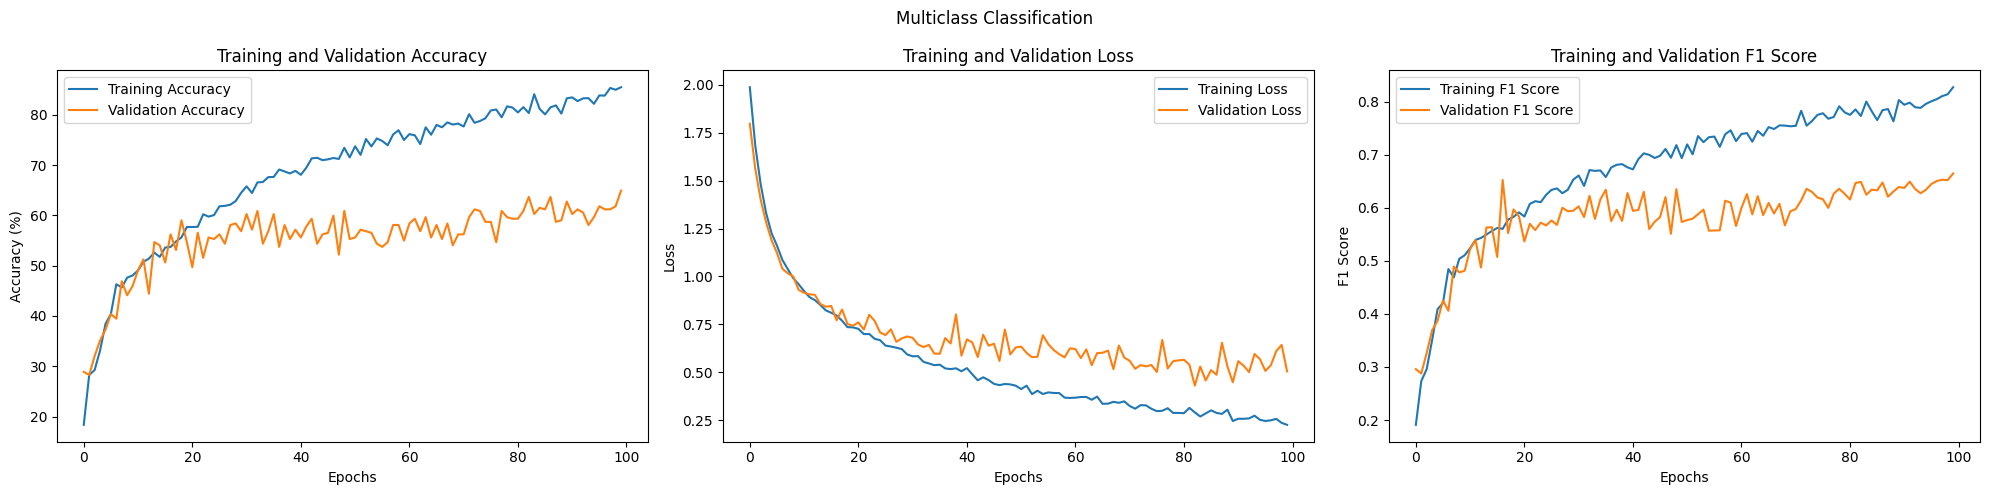

In [59]:
# Plotting model performance
plot_training(train_accuracies, val_accuracies, train_losses, val_losses, train_f1_scores, val_f1_scores, title='Multiclass Classification')

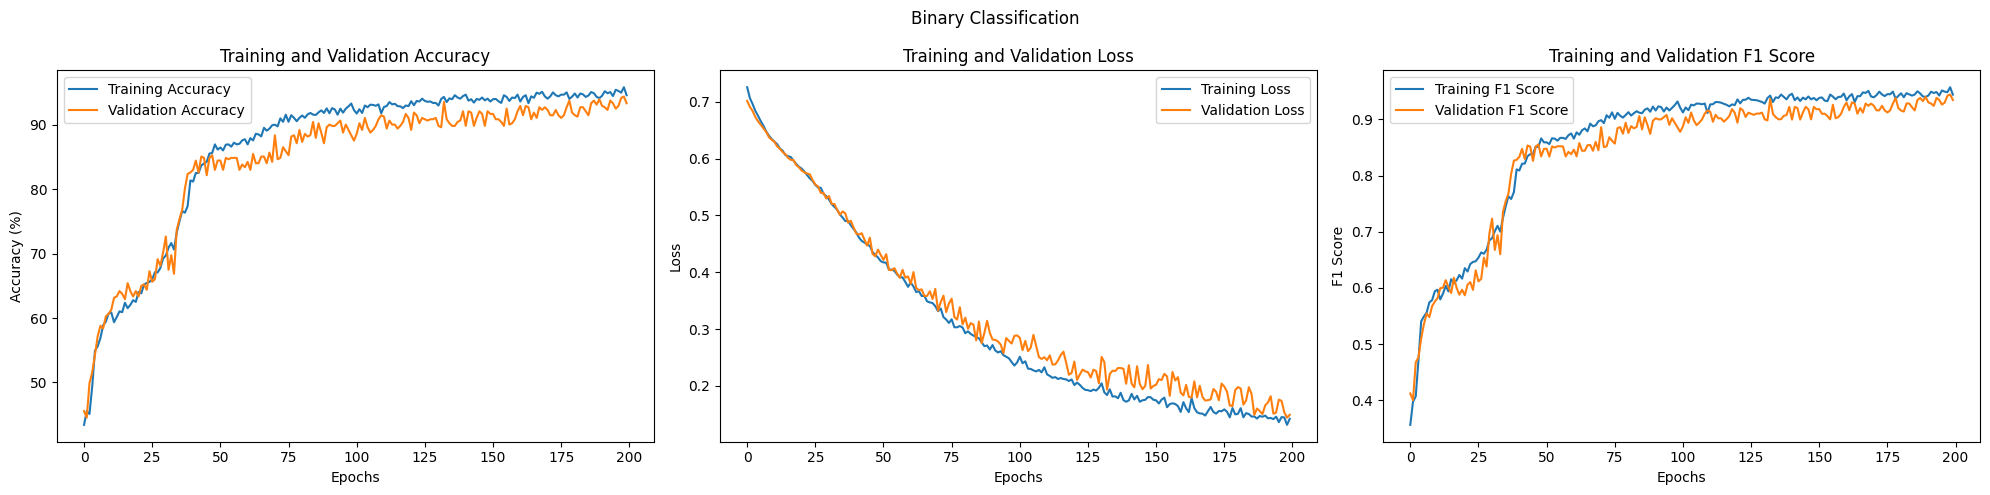

In [54]:
plot_training(train_accuracies_binary, val_accuracies_binary, train_losses_binary, val_losses_binary, train_f1_scores_binary, val_f1_scores_binary, title='Binary Classification')